# Implementing a Declarative Node using the `ddn.pytorch.node` Module

Unlike the previous tutorials, in this notebook we use the [PyTorch](https://pytorch.org/) framework to implement a declarative node. For information on how to use PyTorch, see the [official documentation](https://pytorch.org/docs/stable/index.html) and [tutorials](https://pytorch.org/tutorials/). Here we will show how to implement a declarative node using the `ddn.pytorch.node` module to explore the behavior of the node and solve simple bi-level optimization problems.

We consider the problem of minimizing the KL-divergence between the input $x$ and output $y$ subject to the output forming a valid probablility vector (i.e., the elements of $y$ be positive and sum to one). We will assume strictly positive $x$. The problem can be written formally as

$$
\begin{array}{rll}
y =& \text{argmin}_u & - \sum_{i=1}^{n} x_i \log u_i \\
& \text{subject to} & \sum_{i=1}^{n} u_i = 1
\end{array}
$$
where the positivity constraint on $y$ is automatically satisfied by the domain of the log function.

A nice feature of this problem is that we can solve it in closed-form as
$$
y = \frac{1}{\sum_{i=1}^{n} x_i} x.
$$

However, we will only use this for verification and pretend for now that we do not have a closed-form solution. Instead we will make use of the `scipy.optimize` module to solve the problem via an iterative method. Deriving our deep declarative node from the `LinEqConstDeclarativeNode` class, we will need to implement three functions: the `objective` function, the `solve` function, and the `linear_constraint_parameters` function (the `gradient` function is already implemented for us).


In [1]:
import torch
import numpy as np
import scipy.optimize as opt

import sys
sys.path.append("../")
from ddn.pytorch.node import *

import warnings
#warnings.filterwarnings('ignore')

# create the example node
class MinKL(LinEqConstDeclarativeNode):
    def __init__(self):
        super().__init__()

    def objective(self, xs, y):
        x, = xs
        return -1.0 * torch.einsum('bn,bn->b', (x, y.log()))
    
    def linear_constraint_parameters(self, y):
        A = y.new_ones(1, y.size(-1)) # 1xm
        d = y.new_ones(1) # 1
        return A, d
        
    def solve(self, xs):
        # Solve the constrained optimization problem using scipy's built-in minimize function. Here we
        # initialize the solver at the uniform distribution.
        with torch.no_grad():
            x, = xs
            m = n = x.size(-1)
            u0 = np.ones((m,)) / m
            y = torch.zeros_like(x)
            # Loop over batch:
            for i, xi in enumerate(x):
                result = opt.minimize(lambda u: -1.0 * np.dot(xi.detach().numpy(), np.log(u)), u0,
                                      constraints={'type': 'eq', 'fun': lambda u: np.sum(u) - 1.0},
                                      bounds=opt.Bounds(1e-12, np.inf, keep_feasible=True),
                                      options={'maxiter': 100000, 'ftol': 1e-12})
                y[i, :] = torch.tensor(result.x)
        
        # The solve function must always return two arguments, the solution and context (i.e., cached values needed
        # for computing the gradient). In the case of linearly constrained problems we do not need the dual solution
        # in computing the gradient so we return None for context.
        return y, None

In [2]:
# test the node
node = MinKL()
x = torch.rand(1, 5)
print("Input:\n{}".format(x.squeeze().numpy()))
print("Expected output:\n{}".format((x / x.sum(dim=-1, keepdim=True)).squeeze().numpy()))

y, _ = node.solve((x,))
print("Actual output:\n{}".format(y.squeeze().numpy()))

Input:
[0.36786735 0.813168   0.25292683 0.4886197  0.14241576]
Expected output:
[0.1781442  0.3937864  0.12248287 0.23661996 0.06896655]
Actual output:
[0.1781442  0.3937864  0.12248285 0.23662    0.06896657]


We now plot the function and gradient sweeping the first component of the input $x_1$ from 0.1 to 10.0 while holding the other elements of $x$ constant.

<IPython.core.display.Javascript object>


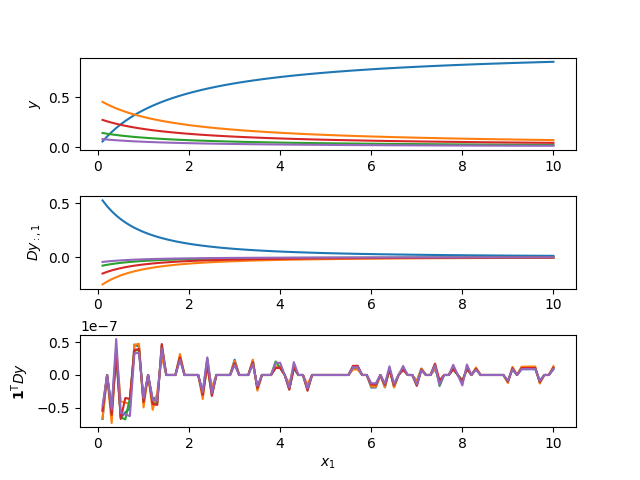

In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt

x1_data = torch.linspace(0.1, 10.0, 100)
x = x.detach() # Don't track computation graph until x
y_data = []
Dy_data = []
vjp_data = []
for x1 in x1_data:
    x_new = x.clone()
    x_new[0, 0] = x1
    x_new.requires_grad = True
    y, _ = node.solve((x_new,))
    y.requires_grad = True
    y_data.append(y.squeeze().detach().numpy())
    # Note that the jacobian function call is inefficient
    # and is used only for teaching and analysis purposes
    Dy_data.append(node.jacobian((x_new,), y)[0][0,:,0].detach().numpy())
    vjp_data.append(node.gradient((x_new,), y)[0][0,:].detach().numpy())
    
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(x1_data, y_data)
plt.ylabel(r"$y$")

plt.subplot(3, 1, 2)
plt.plot(x1_data, Dy_data)
plt.ylabel(r"$Dy_{:,1}$")

plt.subplot(3, 1, 3)
plt.plot(x1_data, vjp_data)
plt.xlabel(r"$x_1$"); plt.ylabel(r"$\mathbf{1}^\mathsf{T}Dy$")

fig.subplots_adjust(hspace=0.5)
plt.show()


### Bi-level optimization

Now let's see whether we can use the node within a bi-level optimization problem. We will attempt to learn an input $x$ that results in an output $y$ with smallest norm-squared. Moreover, we will regularize the norm of $x$ to be close to 10. Given our understanding of KL-divergence this should learn a vector $x$ that is a constant multiple of the ones vector (i.e., all elements of $x$ should be the same). Let's see what happens.

In [ ]:
# define the upper-level objective
def J(xs, y=None):
    """Computes our upper-level objective given both x and y."""
    x, = xs
    if y is None:
        y, _ = node.solve((x,))
    return ((y.norm(dim=-1)) ** 2 + (x.norm(dim=-1) - 10.0) ** 2).mean()

kl_problem = MinKL()
kl_declarative_layer = DeclarativeLayer(kl_problem)

# Solve using gradient descent:
learning_rate = 0.5
x = torch.rand(1, 5, requires_grad=True)
history = [J((x,))]
for i in range(500):
    y = kl_declarative_layer(x)
    z = J((x,), y)
    z.backward()
    x_new = x - learning_rate * x.grad
    x = x_new.detach().requires_grad_(True)
    history.append(J((x,)))

y, _ = node.solve((x,))
x_np = x.detach().squeeze().numpy()
y_np = y.detach().squeeze().numpy()
print("Found x = {} with norm {:0.2f}".format(x_np, np.sqrt(np.dot(x_np, x_np))))
print("Results in y = {}".format(y_np))

fig = plt.figure()
plt.semilogy(history)
plt.ylabel("upper-level objective (log-scale)"); plt.xlabel("iteration")
plt.show()

# Solve using LBFGS:
x = torch.rand(1, 5, requires_grad=True)
history = []
optimizer = torch.optim.LBFGS([x], lr=1, max_iter=100)
def reevaluate():
    optimizer.zero_grad()
    y = kl_declarative_layer(x)
    z = J((x,), y)
    z.backward()
    history.append(z.clone())
    return z
optimizer.step(reevaluate)

y, _ = node.solve((x,))
x_np = x.detach().squeeze().numpy()
y_np = y.detach().squeeze().numpy()
print("Found x = {} with norm {:0.2f}".format(x_np, np.sqrt(np.dot(x_np, x_np))))
print("Results in y = {}".format(y_np))

fig = plt.figure()
plt.semilogy(history)
plt.ylabel("upper-level objective (log-scale)"); plt.xlabel("iteration")
plt.show()